<a href="https://colab.research.google.com/github/maggieesar/Asia-Carbon-Emissions/blob/main/lab03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests


gdf = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/steel.geojson")

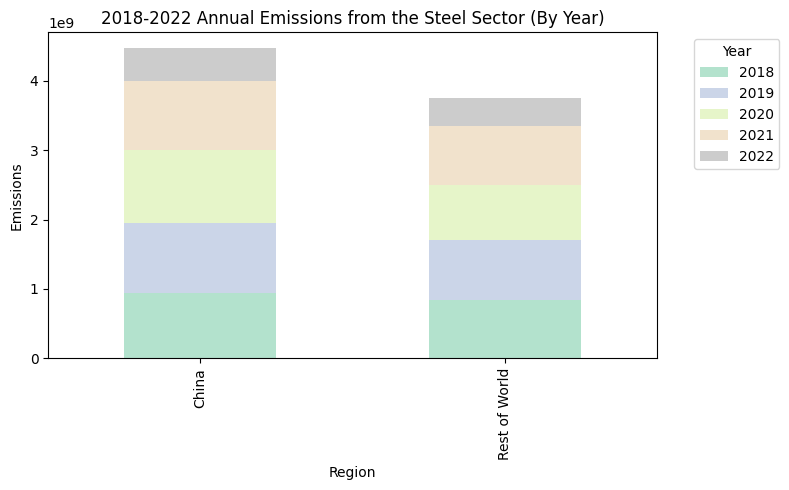

In [ ]:
# -----------------------------#1A--------------------------------
gdf['start_date'] = pd.to_datetime(gdf['start_date'])
gdf['end_date'] = pd.to_datetime(gdf['end_date'])

since_2018 = gdf[gdf['start_date'] >= '2018-01-01'] # World 2018-2022

chn_since_2018 = since_2018[since_2018['iso3_country'] == 'CHN'] # China 2018-2022
rest_since_2018 = since_2018[since_2018['iso3_country'] != 'CHN'] # World - China 2018-2022

chn_steel = chn_since_2018[chn_since_2018['asset_name'].str.contains('Steel', case=False, na=False)] # China Steel Sector
rest_steel = rest_since_2018[rest_since_2018['asset_name'].str.contains('Steel', case=False, na=False)] # World - China Steel Sector

chn_annual_co2 = chn_steel.groupby(chn_steel['start_date'].dt.year)['CO2_emissions'].sum().reset_index(name='China') # China emissions/yr
rest_annual_co2 = rest_steel.groupby(rest_steel['start_date'].dt.year)['CO2_emissions'].sum().reset_index(name='Rest of the World') # World - China emissions/yr

chn_annual_co2.columns = ['year', 'China']
rest_annual_co2.columns = ['year', 'Rest of World']

annual_emissions = pd.merge(chn_annual_co2, rest_annual_co2, on='year', how='outer').fillna(0).set_index('year').T # Total emissions by year

ax = annual_emissions.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Pastel2')

plt.title('2018-2022 Annual Emissions from the Steel Sector (By Year)')
plt.xlabel('Region')
plt.ylabel('Emissions')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------#1B--------------------------------
since_2019 = gdf[gdf['start_date'] >= '2019-01-01']

total_emissions = since_2019['CO2_emissions'].sum() # Total emissions from all facilities since 2019

# Emissions from the top 20 highest-emitting facilities
highest20 = since_2019.groupby('asset_name')['CO2_emissions'].sum().sort_values(ascending=False).head(20)
top20_emissions = highest20.sum()

# Compute the proportion
proportion_top20 = top20_emissions / total_emissions

print(f"Percentage of emissions from the top 20 highest-emitting facilities since 2019: {proportion_top20 * 100:.2f}%")

Percentage of emissions from the top 20 highest-emitting facilities since 2019: 19.72%


In [ ]:
# -----------------------------#2--------------------------------
df = pd.read_csv('https://raw.githubusercontent.com/danhammer/envirods/main/data/farmers-mkts.csv')

def calculate_proportions(df):
    total = len(df)  # total number of markets

    def count(pair):
        item1, item2 = pair
        return len(df[(df[item1] == 'Y') & (df[item2] == 'Y')])     # find all markets selling both items in each pair

    # dictionary of 4 pairs
    pairs = {
        'Wine and Cheese': ('Wine', 'Cheese'),
        'Plants and Nuts': ('Plants', 'Nuts'),
        'Poultry and Eggs': ('Poultry', 'Eggs'),
        'Honey and Flowers': ('Honey', 'Flowers')
    }

    proportions = {}  # dictionary of 4 proportions
    for pair_name, items in pairs.items():
        markets = count(items)
        proportion = markets / total
        proportions[pair_name] = f'{proportion * 100:.2f}%'  # convert to percentage

    return proportions

proportions = calculate_proportions(df)
proportions

{'Wine and Cheese': '5.71%',
 'Plants and Nuts': '14.10%',
 'Poultry and Eggs': '17.91%',
 'Honey and Flowers': '33.08%'}

<ipython-input-23-79fe617bfd57>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


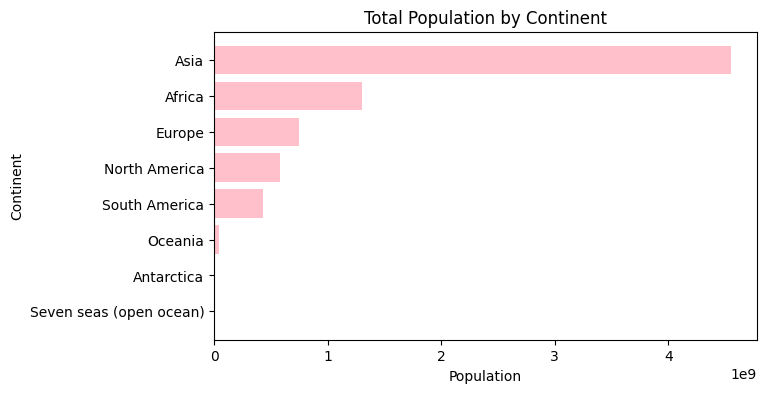

In [ ]:
# -----------------------------#3--------------------------------
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

groups = world.groupby('continent')['pop_est'].sum().reset_index()
sorted_groups = groups.sort_values(by='pop_est', ascending=True)

plt.figure(figsize=(7, 4))
plt.barh(sorted_groups['continent'], sorted_groups['pop_est'], color = 'pink')
plt.xlabel('Population')
plt.ylabel('Continent')
plt.title('Total Population by Continent')
plt.show()

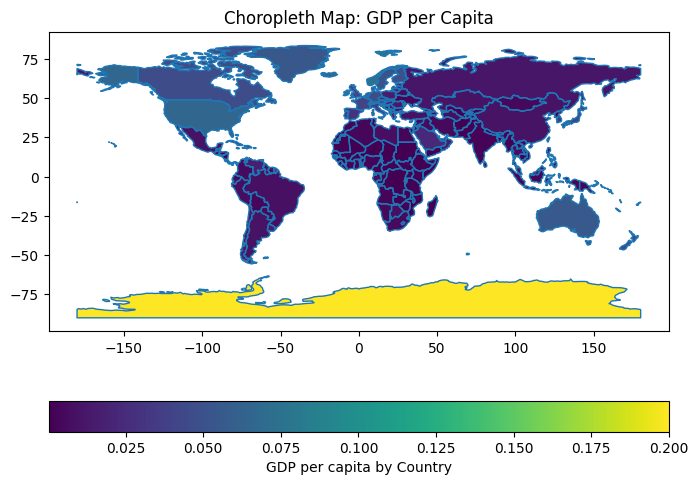

In [ ]:
# -----------------------------#4--------------------------------
world['gdp_per_cap'] = world['gdp_md_est'] / world['pop_est'] # world by GDP per capita

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='gdp_per_cap', ax=ax, legend=True,
           legend_kwds={'label': "GDP per capita by Country",
                        'orientation': "horizontal"})
plt.title('Choropleth Map: GDP per Capita')
plt.show()

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


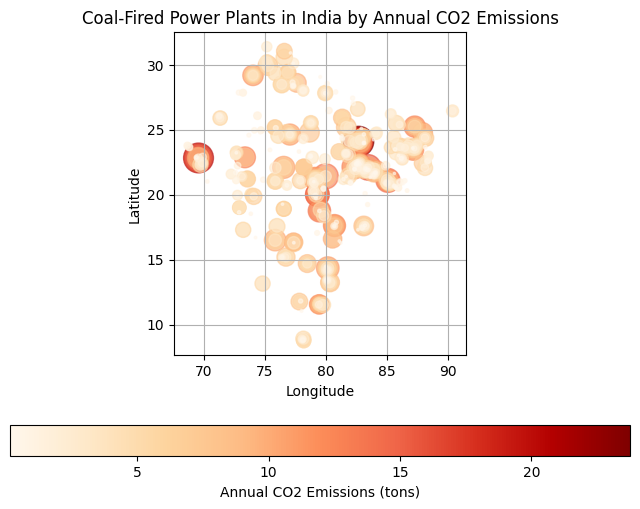

In [ ]:
# -----------------------------#5--------------------------------
coal_map = gpd.read_file('https://global-coal-map-2020.s3.eu-west-2.amazonaws.com/data/coal2020.geojson')
india = coal_map[(coal_map['country'] == 'India') & (coal_map['status'] == 'Operating')]
india['efficiency'] = india['capacity'] / india['annualCarbon']

fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # india power plants by annual CO2 emissions
india.plot(column='annualCarbon', ax=ax, legend=True,
                  legend_kwds={'label': "Annual CO2 Emissions (tons)", 'orientation': "horizontal"},
                  cmap='OrRd', markersize=india['capacity'] / 10, alpha=0.6)
plt.title('Coal-Fired Power Plants in India by Annual CO2 Emissions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

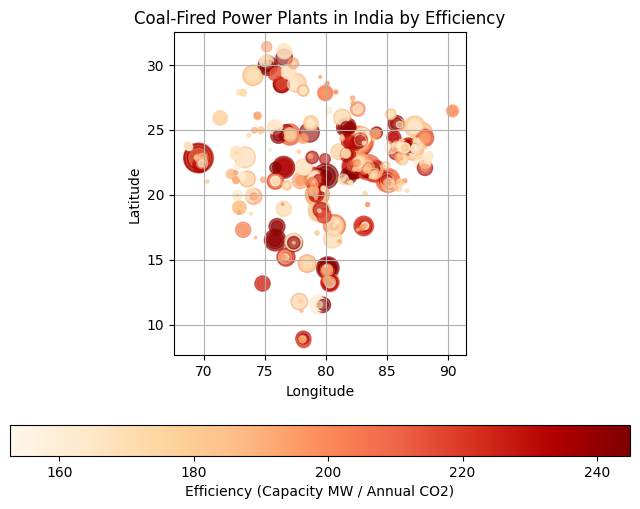

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) # India power plants by efficiency
india.plot(column='efficiency', ax=ax, legend=True,
                  legend_kwds={'label': "Efficiency (Capacity MW / Annual CO2)", 'orientation': "horizontal"},
                  cmap='OrRd', markersize=india['capacity'] / 10, alpha=0.6)
plt.title('Coal-Fired Power Plants in India by Efficiency')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

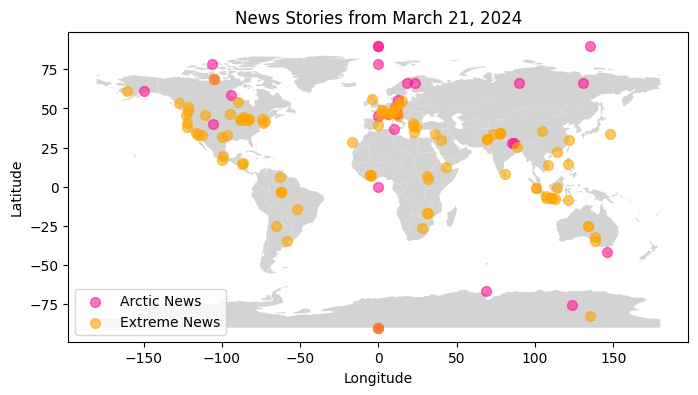

In [ ]:
# # -----------------------------#6--------------------------------
url_arctic = "https://arctic-newswire.ode.partners/api/news?date=2024-03-21&theme=arctic"
url_extreme = "https://arctic-newswire.ode.partners/api/news?date=2024-03-21&theme=extreme"

news_data_arctic = requests.get(url_arctic).json()
news_data_extreme = requests.get(url_extreme).json()

def process_news_data(news_data): # process news stories
    news_list = []
    for story in news_data['data']:
        title = story.get('title', 'No Title')
        lon = float(story.get('lon', None)) # convert coordinates from string to float
        lat = float(story.get('lat', None))
        news_list.append({'title': title, 'latitude': lat, 'longitude': lon})
    return pd.DataFrame(news_list)

df_arctic = process_news_data(news_data_arctic)
df_extreme = process_news_data(news_data_extreme)

gdf_arctic = gpd.GeoDataFrame(df_arctic, geometry=gpd.points_from_xy(df_arctic.longitude, df_arctic.latitude))
gdf_extreme = gpd.GeoDataFrame(df_extreme, geometry=gpd.points_from_xy(df_extreme.longitude, df_extreme.latitude))


fig, ax = plt.subplots(figsize=(8, 5))
world.plot(ax=ax, color='lightgrey') # plot world map

gdf_arctic.plot(ax=ax, color='#FF1493', markersize=50, alpha=0.6, label='Arctic News') # arctic news stories
gdf_extreme.plot(ax=ax, color='orange', markersize=50, alpha=0.6, label='Extreme News') # extreme news stories

plt.legend()
plt.title('News Stories from March 21, 2024')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()